In [ ]:
from towhee import ops, pipe, DataCollection
import os

os.environ['CURL_CA_BUNDLE'] = ''
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ["HTTP_PROXY"] = "127.0.0.1:7890"
os.environ["HTTPS_PROXY"] = "127.0.0.1:7890"

print('load towhee')
# create image embeddings and build index
p = (
    pipe.input('file_name')
    .map('file_name', 'img', ops.image_decode.cv2())
    .map('img', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch32', modality='image'))
    .map('vec', 'vec', ops.towhee.np_normalize())
    .map(('vec', 'file_name'), (), ops.ann_insert.faiss_index('./faiss', 512))
    .output()
)

print('insert image embeddings into faiss index')
for f_name in ['https://raw.githubusercontent.com/towhee-io/towhee/main/assets/dog1.png',
               'https://raw.githubusercontent.com/towhee-io/towhee/main/assets/dog2.png',
               'https://raw.githubusercontent.com/towhee-io/towhee/main/assets/dog3.png']:
    p(f_name)

# Flush faiss data into disk. 
p.flush()
# search image by text
print('search image by text')
decode = ops.image_decode.cv2('rgb')
p = (
    pipe.input('text')
    .map('text', 'vec', ops.image_text_embedding.clip(model_name='clip_vit_base_patch32', modality='text'))
    .map('vec', 'vec', ops.towhee.np_normalize())
    # faiss op result format:  [[id, score, [file_name], ...]
    .map('vec', 'row', ops.ann_search.faiss_index('./faiss', 3))
    .map('row', 'images', lambda x: [decode(item[2][0]) for item in x])
    .output('text', 'images')
)
print('query puppy Corgi')
data = p('puppy Corgi')
print('process done, show results')
DataCollection(data).show()

E:\sourcecode\keep_learning\.venv\Lib\site-packages\pydantic\_internal\_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


load towhee
insert image embeddings into faiss index
search image by text
query puppy Corgi


requirements: Ultralytics requirements ['gitpython>=3.1.30', 'wheel>=0.38.0'] not found, attempting AutoUpdate...
requirements:  AutoUpdate skipped (offline)


Using cache found in C:\Users\ping/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-17 Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


img,object,class
,,book laptop bed

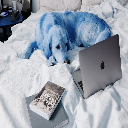
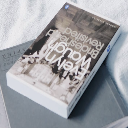
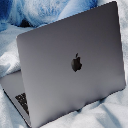
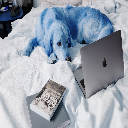

In [3]:
from towhee import pipe, ops, DataCollection
import os

os.environ['CURL_CA_BUNDLE'] = ''
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'
os.environ["HTTP_PROXY"] = "127.0.0.1:7890"
os.environ["HTTPS_PROXY"] = "127.0.0.1:7890"

p = (
    pipe.input('path')
    .map('path', 'img', ops.image_decode())
    .map('img', ('box', 'class', 'score'), ops.object_detection.yolov5())
    .map(('img', 'box'), 'object', ops.image_crop(clamp=True))
    .output('img', 'object', 'class')
)

DataCollection(p('./test.png')).show()